# UBS_lauzhack - Entity resolution model

## 1. Pre-processing

Observed the given dataset and apply the proper transformations to the data in order to better anlyse it and create the model.

In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
import warnings


InteractiveShell.ast_node_interactivity = "all"
#pd.set_option('precision', 3)
display.precision = 3
sns.set()
warnings.filterwarnings('ignore')

# extra imports
from pandas import read_csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
#from statsmodels.genmod.generalized_linear_model import GLM
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox



In [2]:
# Read the CSV files from the 'data' subfolder
account_booking_df = pd.read_csv('data/account_booking_train.csv')
external_parties_df = pd.read_csv('data/external_parties_train.csv')

In [3]:
# Combine the tables with merge using 
combined_data = pd.merge(account_booking_df, external_parties_df, on='transaction_reference_id', how='inner')

In [4]:
#Null count of each variables to know which ones are more relevant to analyze
combined_data.isnull().sum()

transaction_reference_id            0
debit_credit_indicator              0
account_id                          0
transaction_amount                  0
transaction_currency                0
transaction_date                    0
party_role                          0
party_info_unstructured             0
parsed_name                         0
parsed_address_street_name        739
parsed_address_street_number     3030
parsed_address_unit             11064
parsed_address_postal_code       3480
parsed_address_city              1168
parsed_address_state             9107
parsed_address_country           6490
party_iban                       3399
party_phone                      5000
external_id                         0
dtype: int64

In [5]:
# Drop the columns that have more than 50% of missing values and irrelevant information

## External parties data

irrelevant_cols_external = ['party_info_unstructured', 'parsed_address_unit', 'parsed_address_state', 'parsed_address_country']
external_parties_df.drop(columns=irrelevant_cols_external, inplace=True, errors='ignore')

## Accounts booking data
duplicate_ids = account_booking_df[account_booking_df.duplicated(subset='transaction_reference_id', keep=False)]
account_booking_df = account_booking_df[~account_booking_df['transaction_reference_id'].isin(duplicate_ids['transaction_reference_id'])]

irrelevant_cols_booking = ['debit_credit_indicator']
account_booking_df.drop(columns=irrelevant_cols_booking, inplace=True, errors='ignore')

# Merge the two dataframes

merged_df = pd.merge(external_parties_df, account_booking_df, on='transaction_reference_id', how='inner')

merged_df.to_csv('merged_data_cleaned.csv', index=False)

In [6]:

honorifics = ['Mr. ', 'Ms. ', 'Mrs. ', 'Miss ', 'Dr. ', 'Prof. ', 'Rev. ', 'Hon. ', 'mr. ', 'ms. ', 'mrs. ', 'miss ', 'dr. ', 'prof. ', 'rev. ', 'hon. ']
for honorific in honorifics:
    merged_df['parsed_name'] = merged_df['parsed_name'].str.replace(honorific, '')


def delete_duplicates(name):
    def remove_duplicates(text):
        words = text.split()
        seen = set()
        result = []
        for word in words:
            if word.lower() not in seen:
                seen.add(word.lower())
                result.append(word)
        return ' '.join(result)
    
    name['parsed_name'] = name['parsed_name'].apply(remove_duplicates)
    return name

merged_df = delete_duplicates(merged_df)


In [7]:
from metaphone import doublemetaphone

def apply_metaphone(value):
    if isinstance(value, list) or isinstance(value, np.ndarray):  
        return np.nan  
    if pd.isna(value) or not isinstance(value, str):  
        return np.nan
    return doublemetaphone(value.strip().lower())[0] 

def split_and_metaphone(full_name):
    """
    Divide un nombre completo en sus partes (palabras), aplica Metaphone a cada parte,
    y las junta nuevamente con espacios.
    """
    if pd.isna(full_name) or not isinstance(full_name, str):  
        return np.nan

    parts = full_name.strip().split()

    return ' '.join(apply_metaphone(part) for part in parts)

merged_df['parsed_name'] = merged_df['parsed_name'].apply(split_and_metaphone)

print(merged_df['parsed_name'].head())


0          MR M0
1         ASN KM
2      RPRSN JRR
3    ASKSSNLSN K
4      MMJJ PT A
Name: parsed_name, dtype: object


In [ ]:
merged_df['parsed_address_street_name'] = merged_df['parsed_address_street_name'].apply(split_and_metaphone)

print(merged_df['parsed_address_street_name'].head())

merged_df.to_csv('merged_data_cleaned.csv', index=False)

0        ANL PRKS
1          NR MKL
2    RKSL KRSNKPT
3         PRTS ST
4     JN LK S KLN
Name: parsed_address_street_name, dtype: object
Index(['transaction_reference_id', 'party_role', 'parsed_name',
       'parsed_address_street_name', 'parsed_address_street_number',
       'parsed_address_postal_code', 'parsed_address_city', 'party_iban',
       'party_phone', 'external_id', 'account_id', 'transaction_amount',
       'transaction_currency', 'transaction_date', 'block'],
      dtype='object')


<Figure size 1500x1500 with 0 Axes>

Text(0.5, 1.0, 'Grafo de Transacciones entre Enviadores y Receptores')

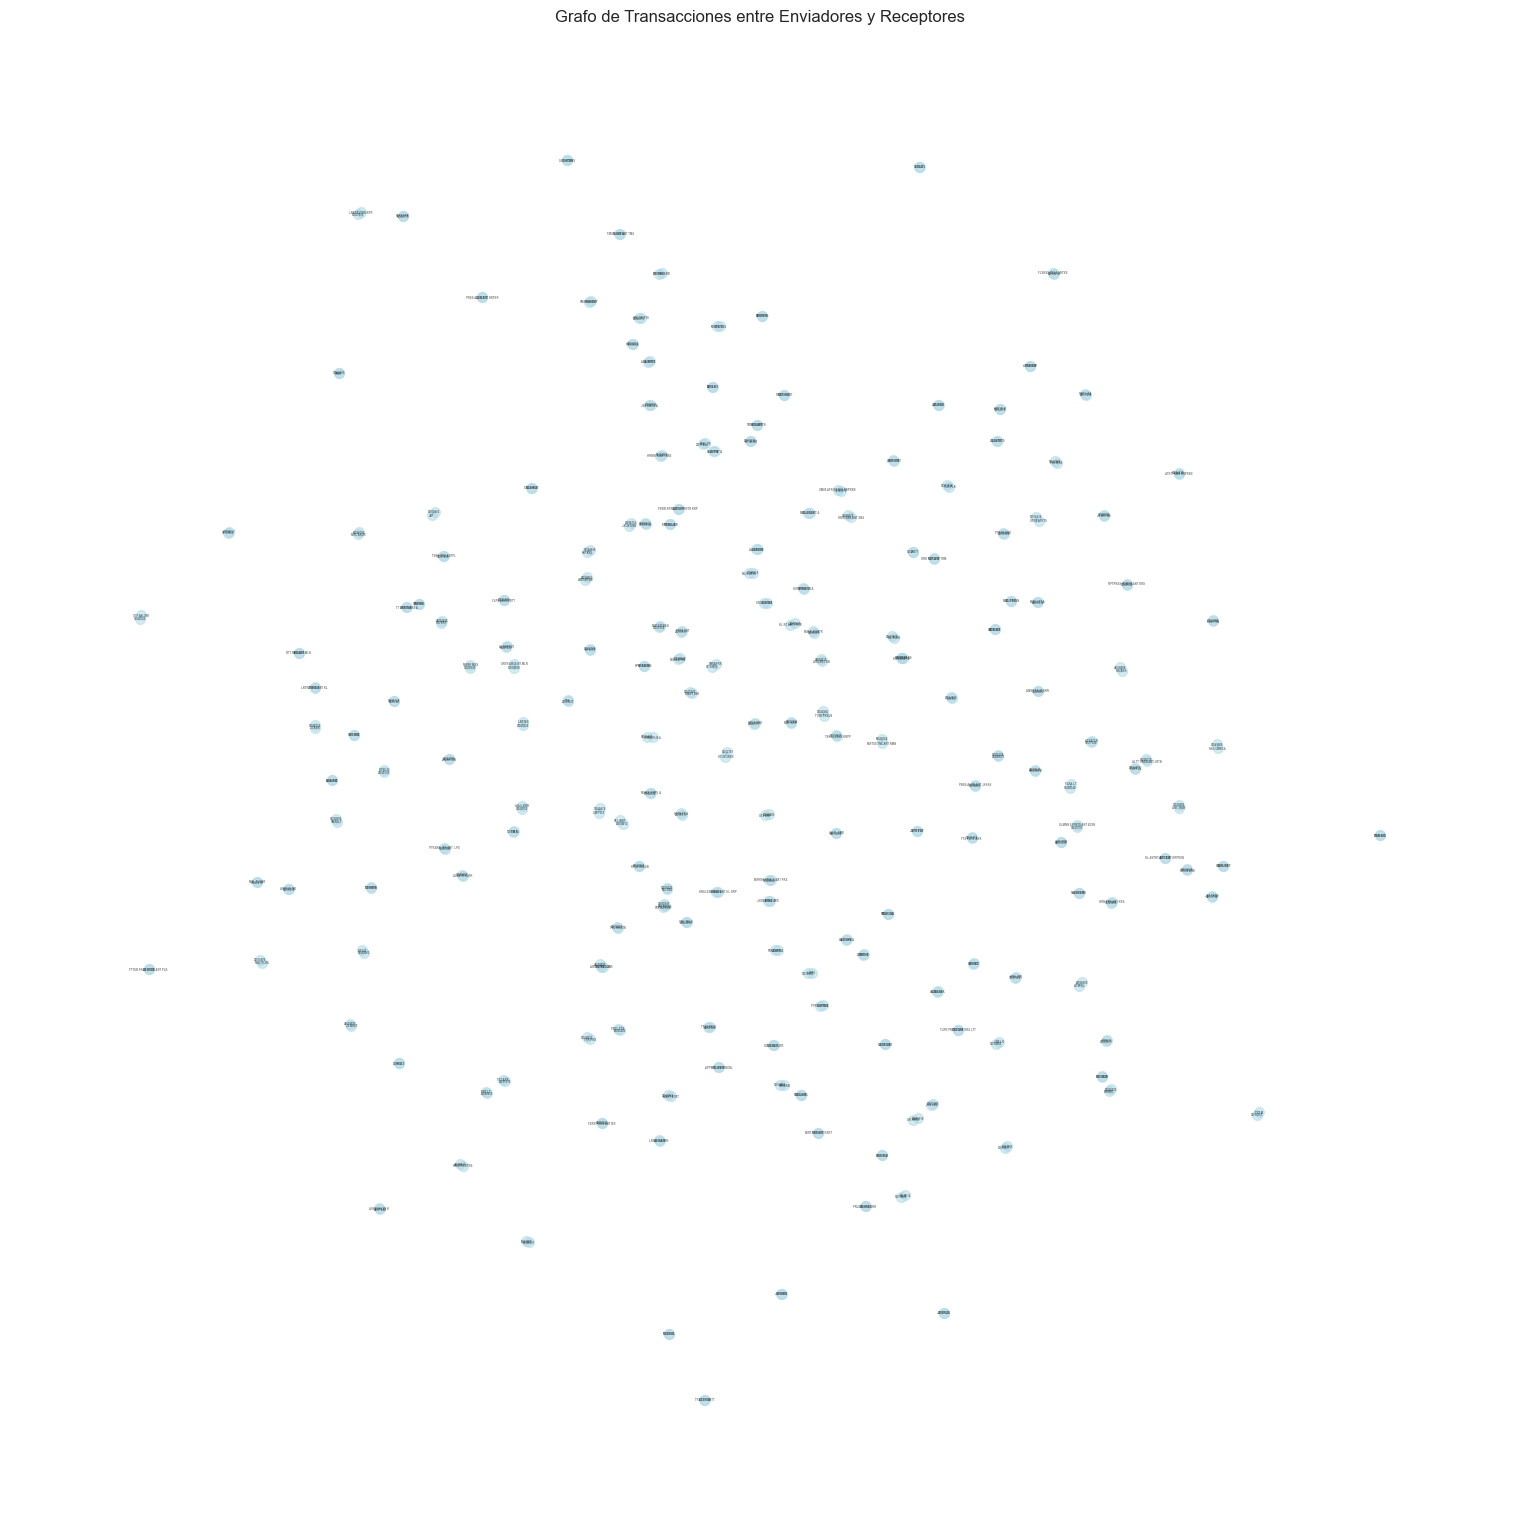

Número de aristas en el grafo: 194
Número de componentes conectados: 191


In [40]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear un grafo vacío
G = nx.Graph()

# Iterar sobre las filas del DataFrame para agregar nodos y aristas
for index, row in merged_df.head(200).iterrows():
    # Obtener el external_id y el rol de la entidad
    external_id = row['external_id']
    role = row['party_role']  # 'sender' o 'receiver' (ajusta según tu nomenclatura)

    # Determinar el nodo según el rol
    if role == 'BENE':
        sender = external_id
        receiver = row['parsed_name']  # O la columna que contenga el nombre del receptor
    else:
        sender = row['parsed_name']  # O la columna que contenga el nombre del enviador
        receiver = external_id

    # Agregar nodos y aristas al grafo
    G.add_node(sender)
    G.add_node(receiver)
    G.add_edge(sender, receiver, weight=row['transaction_amount'])  # Usar el monto de la transacción como peso

# Visualizar el grafo
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G)  # Posicionamiento de los nodos
nx.draw(G, pos, with_labels=True, node_size=50, node_color='lightblue', font_size=2, font_color='black', font_weight='bold', edge_color='black', alpha=0.5)
plt.title('Grafo de Transacciones entre Enviadores y Receptores')
plt.show()

print(f"Número de aristas en el grafo: {G.number_of_edges()}")
print(f"Número de componentes conectados: {nx.number_connected_components(G)}")


In [52]:
# Definir los umbrales para las categorías
thresholds = {
    'small': 1000,
    'medium': 5000
}

# Función para categorizar las transacciones
def categorize_transaction(amount):
    if amount <= thresholds['small']:
        return 'small'
    elif amount <= thresholds['medium']:
        return 'medium'
    else:
        return 'large'

# Aplicar la función al DataFrame
merged_df['transaction_category'] = merged_df['transaction_amount'].apply(categorize_transaction)


# Convertir la columna 'transaction_date' a formato datetime
merged_df['transaction_date'] = pd.to_datetime(merged_df['transaction_date'], errors='coerce')

# Extraer el mes y el día de la semana de la columna 'transaction_date'
merged_df['transaction_month'] = merged_df['transaction_date'].dt.month
# Extraer el día de la semana como un número del 1 al 7 (lunes=1, domingo=7)
merged_df['transaction_day_of_week'] = merged_df['transaction_date'].dt.dayofweek + 1

# Mostrar las primeras filas para verificar
print(merged_df[['transaction_category', 'transaction_month', 'transaction_day_of_week']].head())

# Normalizar las columnas categóricas
merged_df = pd.concat([merged_df, pd.get_dummies(merged_df['transaction_category'], prefix='category')], axis=1)

# Mostrar las primeras filas para verificar
print(merged_df.head())

  transaction_category  transaction_month  transaction_day_of_week
0               medium                 11                        1
1                large                  9                        6
2               medium                  7                        3
3               medium                 11                        5
4                large                 12                        1
           transaction_reference_id party_role  parsed_name  \
0  04ff0d1c680189e3a80c92d86407f0f5       BENE        MR M0   
1  439ab0ad7380e6135ab2ff3fddd4a727        ORG       ASN KM   
2  00cac12d41191a84f9e31aa731a83512        ORG    RPRSN JRR   
3  e4fba5f878dd3453e35973605a783a16       BENE  ASKSSNLSN K   
4  d03d7e4c31878b0255d39e8c3f0ab625        ORG    MMJJ PT A   

  parsed_address_street_name parsed_address_street_number  \
0                   ANL PRKS                      107 107   
1                     NR MKL                          NaN   
2               RKSL KRSNKPT        

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import pdist, squareform

def calculate_similarity(df, column):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df[column].fillna(''))
    cosine_sim = cosine_similarity(tfidf_matrix)
    return pd.DataFrame(cosine_sim, index=df.index, columns=df.index)

# Similaridad en nombres y direcciones
name_similarity = calculate_similarity(merged_df, 'parsed_name')
address_similarity = calculate_similarity(merged_df, 'parsed_address_street_name')


In [10]:
def create_block_key(value, prefix_length=5):
    if pd.isna(value):  # Maneja valores faltantes
        return 'MISSING'
    return value[:prefix_length].lower()

# Aplica el bloqueo en la columna deseada
merged_df['block'] = merged_df['parsed_name'].apply(create_block_key, prefix_length=3)

def create_combined_block(row):
    # Combina prefijos de varias columnas
    name_key = create_block_key(row['parsed_name'], prefix_length=3)
    address_key = create_block_key(row['parsed_address_street_name'], prefix_length=3)
    return f"{name_key}_{address_key}"

merged_df['block'] = merged_df.apply(create_combined_block, axis=1)

blocks = merged_df.groupby('block')


In [11]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Función para calcular similitud con TF-IDF
def calculate_similarity(df, column):
    vectorizer = TfidfVectorizer()
    filled_column = df[column].fillna('MISSING')  # Rellena missings temporalmente
    tfidf_matrix = vectorizer.fit_transform(filled_column)
    cosine_sim = cosine_similarity(tfidf_matrix)
    
    # Opcional: Penaliza similitud para valores originalmente faltantes
    missing_mask = df[column].isna().values
    cosine_sim[missing_mask, :] = 0
    cosine_sim[:, missing_mask] = 0
    
    return cosine_sim


# Función de blocking
def create_block_key(value, prefix_length=5):
    if pd.isna(value):  # Maneja valores faltantes
        return 'MISSING'
    return value[:prefix_length].lower()

# Aplica el bloqueo en la columna deseada
merged_df['block'] = merged_df['parsed_name'].apply(create_block_key, prefix_length=3)

def create_combined_block(row):
    # Combina prefijos de varias columnas
    name_key = create_block_key(row['parsed_name'], prefix_length=3)
    address_key = create_block_key(row['parsed_address_street_name'], prefix_length=3)
    return f"{name_key}_{address_key}"

merged_df['block'] = merged_df.apply(create_combined_block, axis=1)
blocks = merged_df.groupby('block')


# Procesar cada bloque


merged_df['parsed_address_street_name'].fillna(
merged_df['parsed_address_city'].fillna('MISSING'), inplace=True
)

results = []

for block_name, block_data in blocks:
    print(f"Processing block: {block_name}")
    
    if len(block_data) < 2:
        # Si el bloque tiene solo un registro, lo marcamos como un singleton
        block_data['external_id'] = range(len(results), len(results) + len(block_data))
        results.append(block_data)
        continue

    # Similaridad para nombres y direcciones

    name_similarity = calculate_similarity(block_data, 'parsed_name')
    #address_similarity = calculate_similarity(block_data, 'parsed_address_street_name')
    #print(address_similarity)
    
    # Combinar las similitudes
    similarity_matrix = name_similarity #+ 0.3 * address_similarity
    
    # Asegurarse de que los valores de la matriz de similitud estén en el rango [0, 1]
    similarity_matrix = np.clip(similarity_matrix, 0, 1)
    
    # Convertimos la matriz de similitud en distancias
    distance_matrix = 1 - similarity_matrix
    
    # Aplicamos DBSCAN
    db = DBSCAN(eps=0.3, min_samples=2, metric='precomputed')
    clusters = db.fit_predict(distance_matrix)
    
    # Asignamos clusters como external_id
    block_data['external_id'] = clusters + len(results)  # Evita conflictos entre bloques
    results.append(block_data)

# Combinar los resultados de todos los bloques
final_df = pd.concat(results, ignore_index=True)

Processing block:  0r_rtr
Processing block:  ak_rt 
Processing block:  al_jsk
Processing block:  al_nn 
Processing block:  al_tlr
Processing block:  am_n n
Processing block:  ar_ant
Processing block:  as_ as
Processing block:  at_hnt
Processing block:  fr_ fr
Processing block:  hk_krs
Processing block:  hk_lrn
Processing block:  hk_mrk
Processing block:  hk_p0 
Processing block:  hk_tf 
Processing block:  hr_krs
Processing block:  hr_ls 
Processing block:  hr_m0 
Processing block:  hr_rtr
Processing block:  jn_a
Processing block:  jn_lrn
Processing block:  jn_plk
Processing block:  jn_rsl
Processing block:  jn_tms
Processing block:  jn_tnl
Processing block:  k0_jks
Processing block:  kn_rpk
Processing block:  kp_tmp
Processing block:  kr_knk
Processing block:  kr_prn
Processing block:  lr_nkl
Processing block:  m0_ kr
Processing block:  m0_ m0
Processing block:  mk_ kr
Processing block:  mk_jn 
Processing block:  mk_krs
Processing block:  mk_n l
Processing block:  mk_tn 
Processing blo

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='external_id'>

Text(0.5, 1.0, 'Distribución de Clusters')

Text(0.5, 0, 'Cluster ID')

Text(0, 0.5, 'Tamaño del Cluster')

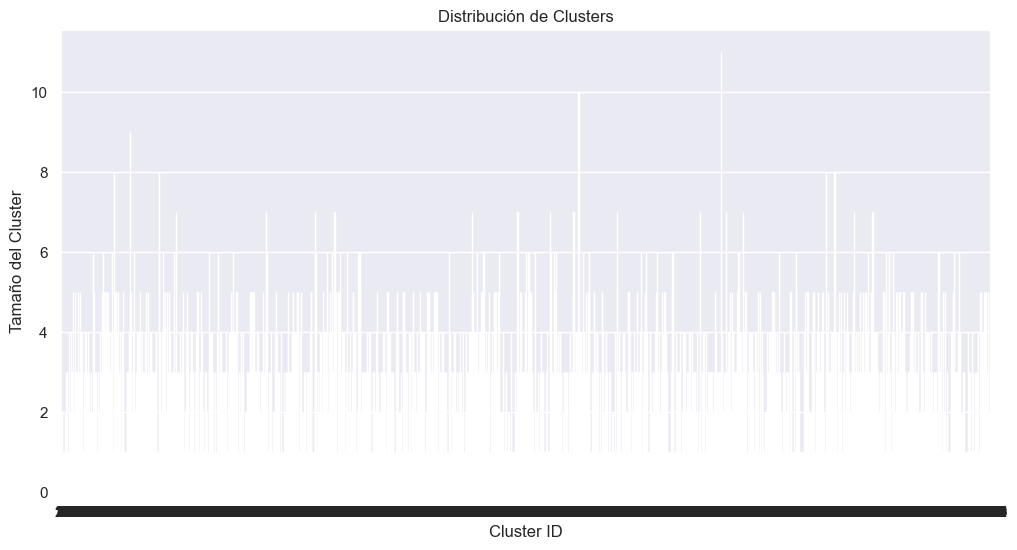

In [12]:
# Visualizar el tamaño de cada cluster
cluster_sizes = final_df['external_id'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values)
plt.title('Distribución de Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('Tamaño del Cluster')
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score
              
# Calculate the TF-IDF matrix for the 'parsed_name' column
tfidf_matrix = calculate_similarity(merged_df, 'parsed_name')

# Usamos la matriz de características original (en este caso, la matriz TF-IDF)
silhouette = silhouette_score(tfidf_matrix, clusters)
print(f"Silhouette Score: {silhouette}")


ValueError: Found input variables with inconsistent numbers of samples: [11064, 4]

### 1.1 Pre-processing of the variable parsed_name

In [ ]:
# Delete honorifics from the names

# Sample data for demonstration
merged_data_cleaned2 = pd.DataFrame({
    'transaction_reference_id': [1, 2, 3, 4, 5],
    'parsed_name': ['Mr. John Doe', 'Dr. Jon Doe', 'Ms. Jane Doe', 'Jonny Doe', 'Prof. Sonya Sonya'],
    'postal_code': ['12345', '12345', '67890', '67891', '67892']
})

def delete_honorifics(name): 
    name['parsed_name'] = name['parsed_name'].str.replace('Mr. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('Ms. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('Mrs. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('Miss ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('Dr. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('Prof. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('Rev. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('Hon. ', '')

delete_honorifics(merged_data_cleaned2)
print(merged_data_cleaned2)

In [ ]:
# Normalize the names

def normalize_names(name):
    name['parsed_name'] = name['parsed_name'].str.lower()

normalize_names(merged_data_cleaned2)
print(merged_data_cleaned2)

In [ ]:
# Delete duplicates in the names

# Function to delete duplicated words in names
def delete_duplicates(name):
    def remove_duplicates(text):
        words = text.split()
        seen = set()
        result = []
        for word in words:
            if word.lower() not in seen:
                seen.add(word.lower())
                result.append(word)
        return ' '.join(result)
    
    name['parsed_name'] = name['parsed_name'].apply(remove_duplicates)
    return name

delete_duplicates(merged_data_cleaned2) 
print(merged_data_cleaned2)

In [ ]:
print(merged_data_cleaned2.columns)


In [ ]:
import networkx as nx
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
#from jellyfish import jaro_winkler_similarity
import pandas as pd
import fuzzy

# Initialize Soundex or Metaphone
metaphone = fuzzy.nysiis  # Uncomment this line to use Metaphone

# Step 2: Indexing (blocking) using Soundex or Metaphone
def create_block_key(name):
    metaphone_code = metaphone(name)  
    return metaphone_code

# Create block keys
#merged_data_cleaned2['block_key'] = merged_data_cleaned2.apply(lambda row: create_block_key(row['parsed_name']), axis=1)

#print(merged_data_cleaned2)


In [ ]:
def split_and_metaphone(full_name):
    """
    Divide un nombre completo en sus partes (palabras), aplica Metaphone a cada parte,
    y las junta nuevamente con espacios.
    """
    if pd.isna(full_name) or not isinstance(full_name, str):  
        return np.nan

    parts = full_name.strip().split()

    return ' '.join(create_block_key(part) for part in parts)

# Apply the function to the 'parsed_name' column
merged_data_cleaned2['block_key'] = merged_data_cleaned2['parsed_name'].apply(split_and_metaphone)
print(merged_data_cleaned2)

### 1.2 Phone pre-processing

In [ ]:
# Phone number normalization

combined_data['party_phone'] = combined_data['party_phone'].str.split('x').str[0]
combined_data['party_phone'] = combined_data['party_phone'].replace(r'\D', '', regex=True)
combined_data['party_phone'] = combined_data['party_phone'].str.lstrip('0')

data = combined_data[['party_phone']]
print(data)

In [ ]:


# Paso 3: Construcción del grafo
graph = nx.Graph()

# Agregar nodos
for idx, row in data.iterrows():
    node_id = row['transaction_reference_id']
    graph.add_node(node_id, attributes=row)

# Agregar aristas basadas en similitud
for node1, node2 in possible_pairs:  # Comparar dentro de cada bloque
    sim_name = jaro_winkler_similarity(graph.nodes[node1]['attributes']['parsed_name'],
                                       graph.nodes[node2]['attributes']['parsed_name'])
    if sim_name > 0.8:
        graph.add_edge(node1, node2)

# Paso 4: Identificar componentes conexos
clusters = list(nx.connected_components(graph))

# Paso 5: Asignar IDs de cluster
cluster_mapping = {node: cluster_id for cluster_id, cluster in enumerate(clusters) for node in cluster}
data['external_id'] = data['transaction_reference_id'].map(cluster_mapping)
